# UNET lane segmentation

In this notebook, we implement a U-NET from scratch to solve the problem of finding the lanes in an image coming from the vehicle front-facing camera. The images are obtained using the CARLA simulator.

## U-NET model
In this section we define the architecture of the U-NET using the Keras library.

In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
  '''
  Standard U-NET model for the multi class segmentation problem.

  The model is not compiled and it should be done externally. This allows for 
  easy test of various loss functions and optimizers.
  '''

  # Define the model
  
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
  s = inputs

  #Contraction path
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = Dropout(0.1)(c1)
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = MaxPooling2D((2, 2))(c2)
    
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = MaxPooling2D((2, 2))(c3)
    
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #Expansive path 
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
  outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    
  model = Model(inputs=[inputs], outputs=[outputs])

  #NOTE: Compile the model in the main program to make it easy to test with various loss functions
  #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  #model.summary()

  return model

## Load the image data set

In [2]:
# Provide access to the images stored in google drive
from google.colab            import files
from google.colab            import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
db_path     = '/content/drive/MyDrive/Colab Notebooks/Computer vision/data/'
masks_path  = '/content/drive/MyDrive/Colab Notebooks/Computer vision/masks/'

In [4]:
import os
import glob
import cv2
import numpy as np

from IPython.display import clear_output
from google.colab.patches import cv2_imshow
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image 

Prepare the raw camera image by:

- Resizing
- Converting to grayscale
- Normalizing the data
- Expanding the dimensions

In [5]:
# Resize images to a smaller size
SIZE_X = 128 
SIZE_Y = 128

# Define the number of classes (Background, left lane, right lane)
n_classes = 3

# Store images as we read them
image_dataset = []
masks_dataset = []

for img_path in glob.glob(os.path.join(db_path, "*.png")):

  # Get the path of the image and the corresponding label
  path_list = img_path.split(os.sep)
  
  temp_path = path_list[:-2]
  temp_path.append('masks')

  img_filename = path_list[-1]
  mask_filename = img_filename[:-4] + '_label' + '.png'

  temp_path.append(mask_filename)
  mask_path = os.sep.join(temp_path)

  # Extract the images
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, (SIZE_X, SIZE_Y))
  img = tf.cast(img, tf.float32) / 255.0 # Normalize
  image_dataset.append(img)

  # Read the label
  img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, (SIZE_X, SIZE_Y), interpolation=cv2.INTER_NEAREST) # Inter nearest interpolation needed to avoid having fake labels
  masks_dataset.append(img)

masks_dataset = np.array(masks_dataset)
image_dataset = np.array(image_dataset)

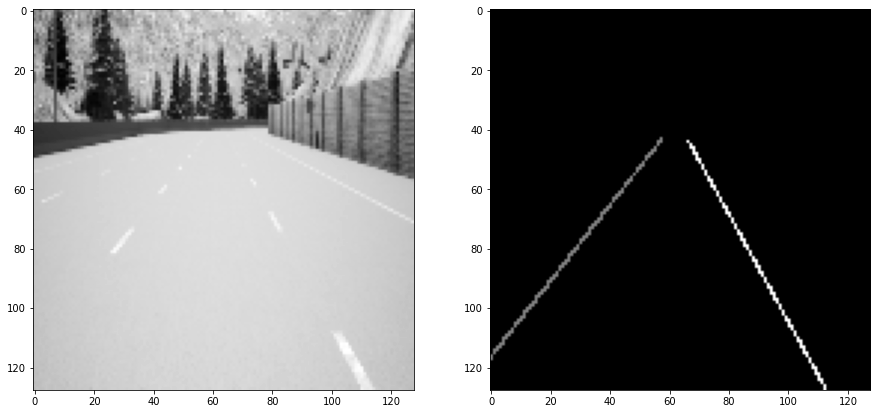

In [6]:
fig, ax = plt.subplots(1,2, figsize=(15, 15))

img_idx = 400
ax[0].imshow(image_dataset[img_idx], cmap='gray')
ax[1].imshow(masks_dataset[img_idx], cmap='gray')

In [7]:
image_dataset = np.expand_dims(image_dataset, axis=3)

In [8]:
masks_dataset = np.expand_dims(masks_dataset, axis=3)

## Divide into training and test data

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_dataset, masks_dataset)

In [10]:
np.shape(X_train)

(354, 128, 128, 1)

In [11]:
np.shape(y_train)

(354, 128, 128, 1)

In [12]:
np.shape(X_test)

(118, 128, 128, 1)

## Convert the mask image into a categorical variable

In a way it is a one hot encoding for each class and each of the encodings is a channel in a new image.

In [ ]:
from keras.utils import to_categorical

# Changing the mask to a three dimensional array where each channel represents a class

train_masks_categorical = to_categorical(y_train, num_classes=n_classes)
y_train_cat             = train_masks_categorical

tests_masks_categorical = to_categorical(y_test, num_classes=n_classes)
y_test_cat              = tests_masks_categorical

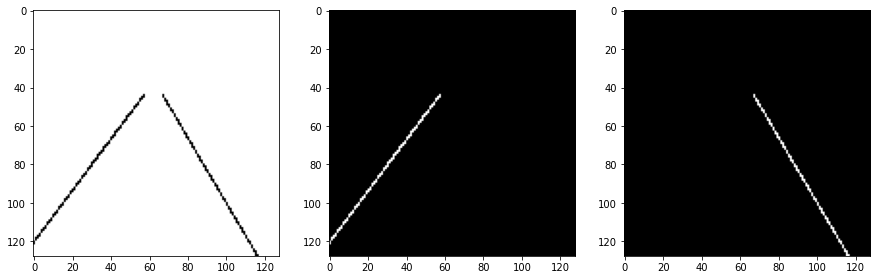

In [ ]:
# Sanity check: Display the class channels of the categorical image
fig, ax = plt.subplots(1,3, figsize=(15, 15))
ax[0].imshow(train_masks_categorical[2,:,:,0], cmap='gray') # Background
ax[1].imshow(train_masks_categorical[2,:,:,1], cmap='gray') # Left lane
ax[2].imshow(train_masks_categorical[2,:,:,2], cmap='gray') # Right lane

## Train the U-NET model

Compile the model

In [ ]:
IMG_HEIGHT   = X_train.shape[1]
IMG_WIDTH    = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(name='MeanIoU', num_classes=3)])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def __init__(self, x_test, y_test):
    self.x_test = x_test
    self.y_test = y_test
  
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    
    # Get the predictions for the first image
    y_pred=model.predict(self.x_test)
    y_pred_argmax=np.argmax(y_pred, axis=3)

    fig, ax = plt.subplots(1,3, figsize=(15, 15))
    ax[0].imshow(self.x_test[0][:,:,0], cmap='gray') # Raw data
    ax[1].imshow(self.y_test[0][:,:,0], cmap='gray') # Ground truth label
    ax[2].imshow(y_pred_argmax[0], cmap='gray')      # Predicted label
    plt.show()

    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Train the model

4/4 [==============================] - 0s 19ms/step


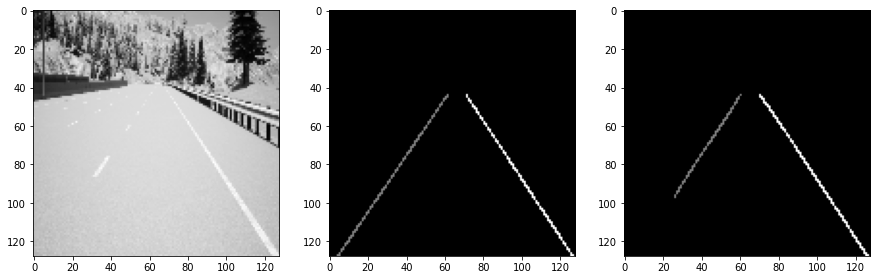


Sample Prediction after epoch 50

23/23 [==============================] - 2s 73ms/step - loss: 0.0156 - accuracy: 0.9932 - MeanIoU: 0.9092 - val_loss: 0.0153 - val_accuracy: 0.9935 - val_MeanIoU: 0.9060


In [ ]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    callbacks=[DisplayCallback(X_test, y_test)],
                    shuffle=False)

## Evaluate the model

4/4 [==============================] - 0s 40ms/step - loss: 0.0153 - accuracy: 0.9935 - MeanIoU: 0.9060
Accuracy is =  99.35380220413208 %


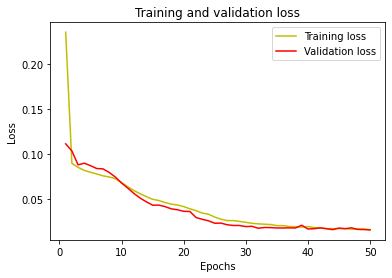

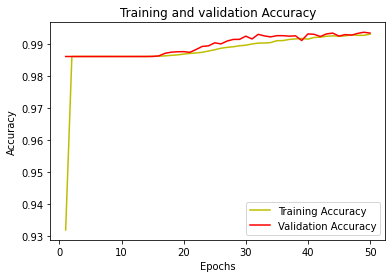

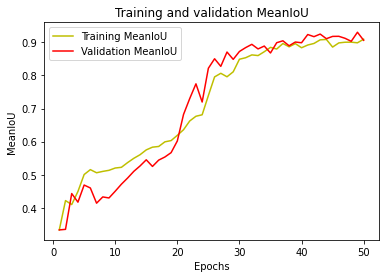

In [ ]:
#Evaluate the model
	# evaluate model
_, acc, mean_iou = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")

##################################################################
# Plot loss and metrics at each epoch
##################################################################

# Loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# MeanIoU
acc = history.history['MeanIoU']
val_acc = history.history['val_MeanIoU']

plt.plot(epochs, acc, 'y', label='Training MeanIoU')
plt.plot(epochs, val_acc, 'r', label='Validation MeanIoU')
plt.title('Training and validation MeanIoU')
plt.xlabel('Epochs')
plt.ylabel('MeanIoU')
plt.legend()
plt.show()

## Test the predictions

4/4 [==============================] - 0s 32ms/step


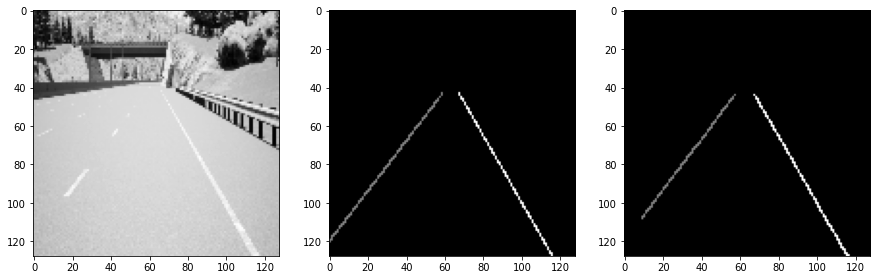

In [ ]:
# Get the predictions for the first image
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

img_index = 15

fig, ax = plt.subplots(1,3, figsize=(15, 15))
ax[0].imshow(X_test[img_index][:,:,0], cmap='gray') # Raw data
ax[1].imshow(y_test[img_index][:,:,0], cmap='gray') # Ground truth label
ax[2].imshow(y_pred_argmax[img_index], cmap='gray') # Predicted label
plt.show()

In [ ]:
np.shape(np.expand_dims(X_test[0], axis=0))

(1, 128, 128, 1)

In [ ]:
single_pred = model.predict(np.expand_dims(X_test[0], axis=0))
y_pred_argmax=np.argmax(single_pred, axis=3)

1/1 [==============================] - 0s 61ms/step


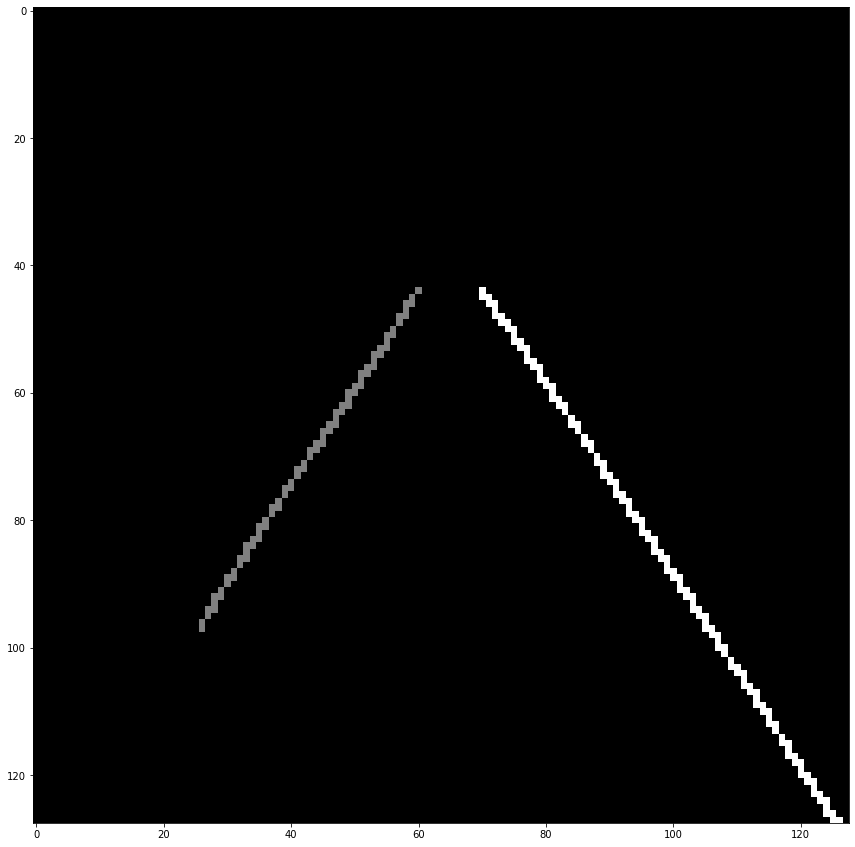

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 15))
ax.imshow(y_pred_argmax[0], cmap='gray') # Raw data

## Save the model

In [ ]:
model.save('my_model.h5')

In [ ]:
my_model = tf.keras.models.load_model('my_model.h5')